<a href="https://colab.research.google.com/github/caranugent/DE300/blob/main/09b_Analyzing_an_article_through_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (EX) Analyzing an article through PySpark

In [ ]:
import os
os.environ["JAVA_HOME"] = r"C:\Program Files\Java\jdk-11.0.2"
os.environ["SPARK_HOME"] = r"C:\Program Files\Spark\spark-3.5.5-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
                     .appName("Analyzing an unknown article.")
                     .getOrCreate())


In [ ]:
spark

In [ ]:
sc = spark.sparkContext

In [ ]:
## documentation
spark.read??

In [ ]:
file_path = r'Pope_Article_Text.txt'

In [ ]:
article = spark.read.text(file_path)

In [ ]:
article

DataFrame[value: string]

In [ ]:
article.printSchema()

root
 |-- value: string (nullable = true)



In [ ]:
article.select(article.value)

DataFrame[value: string]

In [ ]:
article.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                    |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|New Pope Leo XIV cites AI’s challenge to human dignity in his name choice                                                                                                |
|Pope Leo XIV named himself after another pope with a legacy of social reform.                                                                                            |
|By Cecily Mauran  on May 11, 2025                                                                                                          

In [ ]:
from pyspark.sql.functions import col

In [ ]:
article.select(article.value)
article.select(article['value'])
article.select(col('value'))
article.select('value')

DataFrame[value: string]

In [ ]:
from pyspark.sql.functions import col, split

lines = article.select(
    split(col('value'), " ").alias('line')
)
# have split up the liens into a list of words

In [ ]:
lines.printSchema() # converted from string to array of elements

root
 |-- line: array (nullable = true)
 |    |-- element: string (containsNull = false)



In [ ]:
lines.show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|line                                                                                                                                                                                                     |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[New, Pope, Leo, XIV, cites, AI’s, challenge, to, human, dignity, in, his, name, choice]                                                                                                                 |
|[Pope, Leo, XIV, named, himself, after, another, pope, with, a, legacy, of, social, reform.]                                                                                           

In [ ]:
lines

DataFrame[line: array<string>]

In [ ]:
# BEFORE CLEANING: list of strings doesn't work with map, create a col of words

from pyspark.sql.functions import explode

words = lines.select(explode(col("line")).alias('word'))

In [ ]:
words.printSchema()

root
 |-- word: string (nullable = false)



In [ ]:
# PYSPARK doesn't do anything unless you actually call show:
words.show(10)

+---------+
|     word|
+---------+
|      New|
|     Pope|
|      Leo|
|      XIV|
|    cites|
|     AI’s|
|challenge|
|       to|
|    human|
|  dignity|
+---------+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import lower

words_lower = words.select(lower(col("word")).alias('word_lower'))

In [ ]:
words_lower.show(10)

+----------+
|word_lower|
+----------+
|       new|
|      pope|
|       leo|
|       xiv|
|     cites|
|      ai’s|
| challenge|
|        to|
|     human|
|   dignity|
+----------+
only showing top 10 rows



In [ ]:
# IN CLEANING: typically want to clean out punctuations
from pyspark.sql.functions import regexp_extract

words_clean = words_lower.select(
    regexp_extract(col("word_lower"), r"(\W+)?([a-z]+)", 2).alias("word_clean")
)

In [ ]:
words_clean.show(10)

+----------+
|word_clean|
+----------+
|       new|
|      pope|
|       leo|
|       xiv|
|     cites|
|        ai|
| challenge|
|        to|
|     human|
|   dignity|
+----------+
only showing top 10 rows



In [ ]:
words_nonull = words_clean.where(col("word_clean") != "")

words_nonull.show(10) #0)

+----------+
|word_clean|
+----------+
|       new|
|      pope|
|       leo|
|       xiv|
|     cites|
|        ai|
| challenge|
|        to|
|     human|
|   dignity|
+----------+
only showing top 10 rows



In [ ]:
groups = words_nonull.groupBy(col("word_clean"))

In [ ]:
groups

GroupedData[grouping expressions: [word_clean], value: [word_clean: string], type: GroupBy]

In [ ]:
counts = groups.count()

In [ ]:
counts.show(10)

+-----------+-----+
| word_clean|count|
+-----------+-----+
|interaction|    1|
|  partially|    1|
|       farm|    1|
|     duties|    1|
|        day|    1|
|   rejected|    1|
|     intend|    1|
|  cardinals|    1|
| production|    1|
|        two|    1|
+-----------+-----+
only showing top 10 rows



In [ ]:
# order counts by frequency (decreasing)
counts.orderBy('count', ascending=False).show(10)

+----------+-----+
|word_clean|count|
+----------+-----+
|       the|   35|
|        of|   23|
|        in|   16|
|       and|   14|
|        to|   14|
|       leo|   12|
|      pope|   12|
|        ai|    8|
|         a|    8|
|       his|    8|
+----------+-----+
only showing top 10 rows



In [ ]:
# CAN CHANGE ALL OPS TOGETHER, don't need to keep recreating dfs

import pyspark.sql.functions as F

counts = (
    spark.read.text(file_path)
     .select(F.split(F.col('value'), ' ').alias('line'))
     .select(F.explode(F.col('line')).alias('word'))
     .select(F.lower(F.col('word')).alias('word'))
     .select(F.regexp_extract(F.col('word'), r"(\W+)?([a-z]+)", 2).alias('word'))
     .where(F.col('word') != "")
     .groupby('word')
     .count()
)

In [ ]:
counts.show(10)

+-----------+-----+
|       word|count|
+-----------+-----+
|interaction|    1|
|  partially|    1|
|       farm|    1|
|     duties|    1|
|        day|    1|
|   rejected|    1|
|     intend|    1|
|  cardinals|    1|
| production|    1|
|        two|    1|
+-----------+-----+
only showing top 10 rows



**IN-CLASS EXERCISE**

In [ ]:
cleaned = (
    spark.read.text(file_path)
     .select(F.split(F.col('value'), ' ').alias('line'))
     .select(F.explode(F.col('line')).alias('word'))
     .select(F.lower(F.col('word')).alias('word'))
     .select(F.regexp_extract(F.col('word'), r"(\W+)?([a-z]+)", 2).alias('word'))
     .where(F.col('word') != "")
)

In [ ]:
# 1. Return the number of words by word length.
  # F.length() returns the length of a word
lengths = cleaned.select(
  F.length(
        F.col('word')
    ).alias('length')
)

lengths.groupby('length').count().orderBy('length', ascending=True).show(30)


+------+-----+
|length|count|
+------+-----+
|     1|    9|
|     2|   85|
|     3|  104|
|     4|   54|
|     5|   39|
|     6|   49|
|     7|   44|
|     8|   28|
|     9|   22|
|    10|   24|
|    11|    7|
|    12|    7|
|    13|    2|
|    17|    1|
+------+-----+



In [ ]:
# 2. Return the number of each alphabet used in the article.
  # filter / where
  # where(F.col('column').isin(['x', 'y', 'z'])) filters so that only values equals x, y, or z remain
letters = cleaned.select(
    F.explode(F.split(F.col('word'), ""))
)

letters.groupby('col').count().orderBy('col').show(30)


+---+-----+
|col|count|
+---+-----+
|  a|  189|
|  b|   27|
|  c|  106|
|  d|   80|
|  e|  287|
|  f|   68|
|  g|   35|
|  h|  119|
|  i|  210|
|  j|    5|
|  k|    8|
|  l|  122|
|  m|   56|
|  n|  154|
|  o|  206|
|  p|   61|
|  q|    3|
|  r|  152|
|  s|  144|
|  t|  171|
|  u|   57|
|  v|   28|
|  w|   30|
|  x|   15|
|  y|   33|
|  z|    4|
+---+-----+



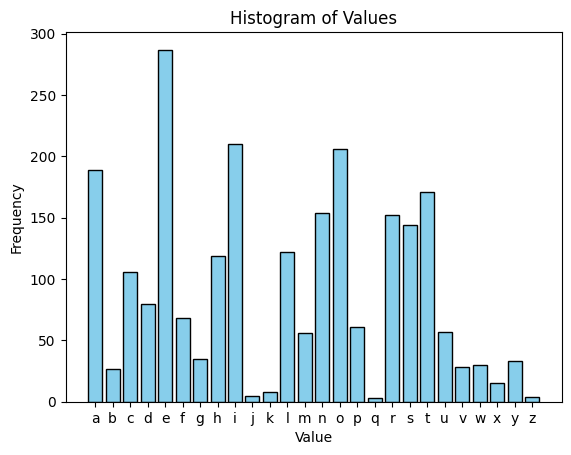

In [ ]:
# 3. Draw a histogram for the number of alphabets used, ordered by alphabetical order.
import matplotlib.pyplot as plt

letters_df = letters.groupby('col').count().orderBy('col')
data = letters_df.collect()

alpha = [row['col'] for row in data]
counts = [row['count'] for row in data]

# Create the histogram
plt.bar(alpha, counts, color='skyblue', edgecolor='black')
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()